In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load Wine dataset
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

# Split into features and labels
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

# Standardize features
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [2]:
import numpy as np

# Compute covariance matrix
cov_mat = np.cov(X_train_std.T)

# Perform eigendecomposition
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

# Sort eigenvalues in descending order
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

# Create projection matrix (top 2 components)
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))

# Transform training data
X_train_pca = X_train_std.dot(w)

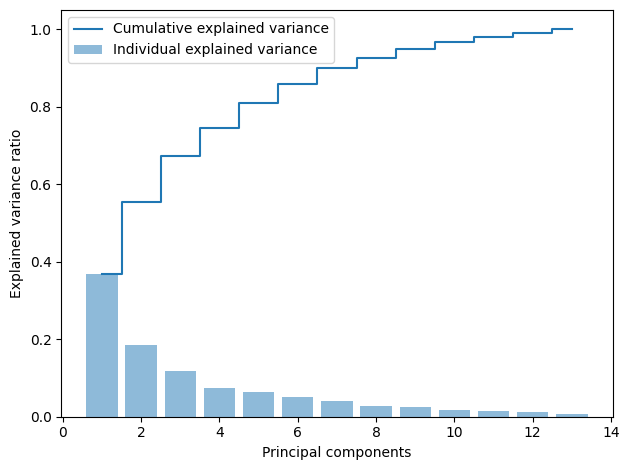

In [3]:
import matplotlib.pyplot as plt

# Calculate explained variance ratios
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# Plot
plt.bar(range(1, len(var_exp) + 1), var_exp, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1, len(cum_var_exp) + 1), cum_var_exp, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca_sk = pca.fit_transform(X_train_std)
X_test_pca_sk = pca.transform(X_test_std)

C:\Users\smabu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\smabu\AppData\Local\Temp\ipykernel_29816\1090379981.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=X[y == cl, 0],
C:\Users\smabu\AppData\Local\Temp\ipykernel_29816\1090379981.py:25: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may chang

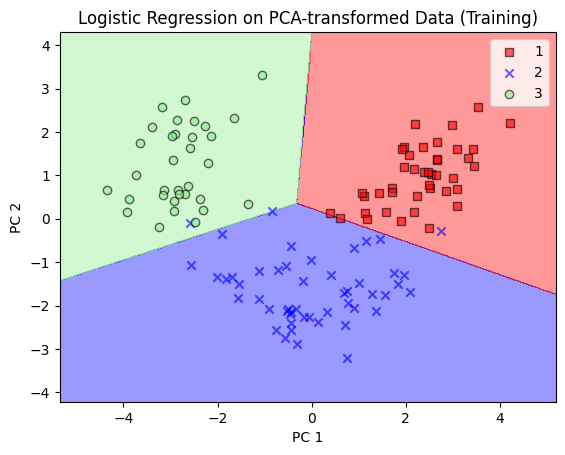

Test Accuracy: 0.926


In [5]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr.fit(X_train_pca_sk, y_train)

# Helper function to plot decision regions (from the book)
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend(loc='best')

# Plot decision regions for training set
plot_decision_regions(X_train_pca_sk, y_train, classifier=lr)
plt.title('Logistic Regression on PCA-transformed Data (Training)')
plt.show()

# Check accuracy on test set
print('Test Accuracy: %.3f' % lr.score(X_test_pca_sk, y_test))

In [6]:
#Part 2
# Calculate mean vectors for each class
mean_vecs = [np.mean(X_train_std[y_train == label], axis=0) for label in np.unique(y_train)]

d = X.shape[1]  # number of features
S_W = np.zeros((d, d)) # Within-class scatter matrix
for label, mv in zip(np.unique(y_train), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter

# Between-class scatter matrix
mean_overall = np.mean(X_train_std, axis=0)
S_B = np.zeros((d, d))
for i, mv in enumerate(mean_vecs):
    n = X_train[y_train == i + 1].shape[0]
    mv = mv.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n * (mv - mean_overall).dot((mv - mean_overall).T)

In [7]:
# Solve generalized eigenvalue problem for S_W^{-1} S_B
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

# Sort eigenvalues in descending order
eigen_pairs = sorted([(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))], key=lambda k: k[0], reverse=True)

# Create projection matrix (top 2 eigenvectors)
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
               eigen_pairs[1][1][:, np.newaxis].real))

# Transform training data
X_train_lda = X_train_std.dot(w)

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda_sk = lda.fit_transform(X_train_std, y_train)
X_test_lda_sk = lda.transform(X_test_std)


C:\Users\smabu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\smabu\AppData\Local\Temp\ipykernel_29816\1090379981.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=X[y == cl, 0],
C:\Users\smabu\AppData\Local\Temp\ipykernel_29816\1090379981.py:25: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may chang

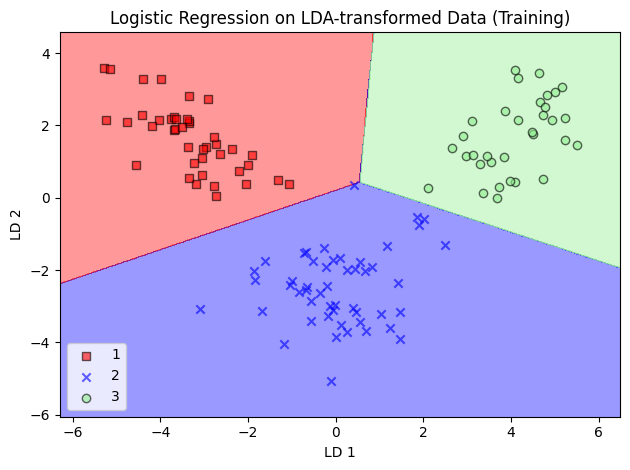

Test Accuracy: 1.000


In [9]:
lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr.fit(X_train_lda_sk, y_train)

plot_decision_regions(X_train_lda_sk, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.title('Logistic Regression on LDA-transformed Data (Training)')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

print('Test Accuracy: %.3f' % lr.score(X_test_lda_sk, y_test))

In [19]:
import time
from sklearn.linear_model import LogisticRegression

#Performance on Original Data
start_time = time.time()
lr_orig = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr_orig.fit(X_train_std, y_train)
orig_accuracy = lr_orig.score(X_test_std, y_test)
orig_time = time.time() - start_time

# Performance on PCA-transformed Data
start_time = time.time()
lr_pca = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr_pca.fit(X_train_pca_sk, y_train)
pca_accuracy = lr_pca.score(X_test_pca_sk, y_test)
pca_time = time.time() - start_time

# Performance on LDA-transformed Data
start_time = time.time()
lr_lda = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr_lda.fit(X_train_lda_sk, y_train)
lda_accuracy = lr_lda.score(X_test_lda_sk, y_test)
lda_time = time.time() - start_time

print(f"Original Data Test Accuracy: {orig_accuracy:.3f}, Computation Time: {orig_time:.5f} seconds")
print(f"PCA Data Test Accuracy: {pca_accuracy:.3f}, Computation Time: {pca_time:.5f} seconds")
print(f"LDA Data Test Accuracy: {lda_accuracy:.3f}, Computation Time: {lda_time:.5f} seconds")

Original Data Test Accuracy: 1.000, Computation Time: 0.01512 seconds
PCA Data Test Accuracy: 0.926, Computation Time: 0.01103 seconds
LDA Data Test Accuracy: 1.000, Computation Time: 0.01338 seconds


C:\Users\smabu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\smabu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\smabu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [10]:
### Step 3.1: Implement RBF Kernel PCA

from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.
    """
    # Calculate pairwise squared Euclidean distances
    sq_dists = pdist(X, 'sqeuclidean')
    # Convert pairwise distances into a square matrix
    mat_sq_dists = squareform(sq_dists)
    # Compute the symmetric kernel matrix
    K = np.exp(-gamma * mat_sq_dists)
    # Center the kernel matrix
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    # Obtaining eigenpairs from the centered kernel matrix
    eigvals, eigvecs = eigh(K)
    # Collect top k eigenvectors (projected samples)
    X_pc = np.column_stack([eigvecs[:, -i] for i in range(1, n_components+1)])
    return X_pc

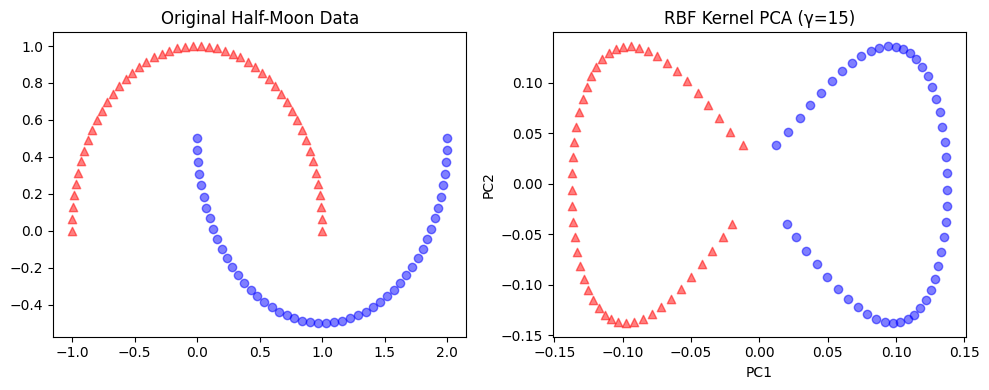

In [11]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, random_state=123)
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.scatter(X[y==0, 0], X[y==0, 1], color='red', marker='^', alpha=0.5)
ax1.scatter(X[y==1, 0], X[y==1, 1], color='blue', marker='o', alpha=0.5)
ax1.set_title('Original Half-Moon Data')

ax2.scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], color='red', marker='^', alpha=0.5)
ax2.scatter(X_kpca[y==1, 0], X_kpca[y==1, 1], color='blue', marker='o', alpha=0.5)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_title('RBF Kernel PCA (γ=15)')
plt.tight_layout()
plt.show()

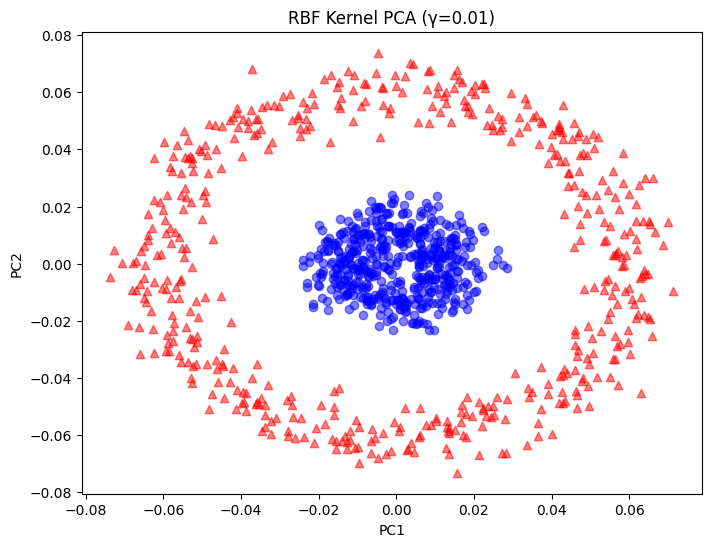

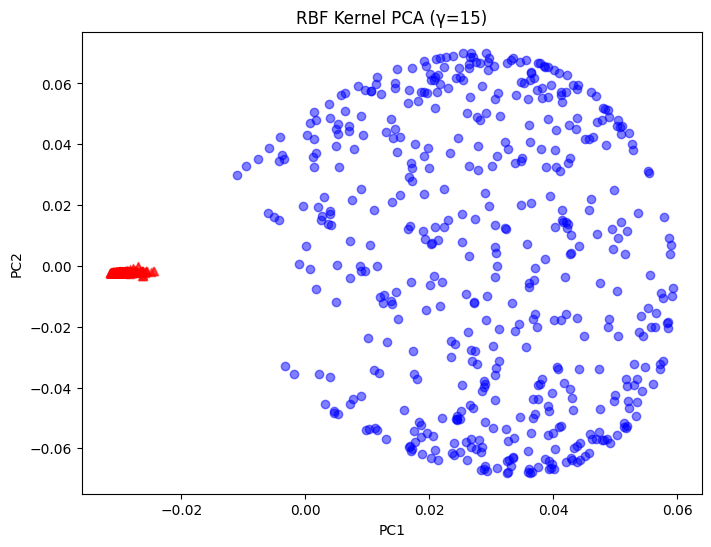

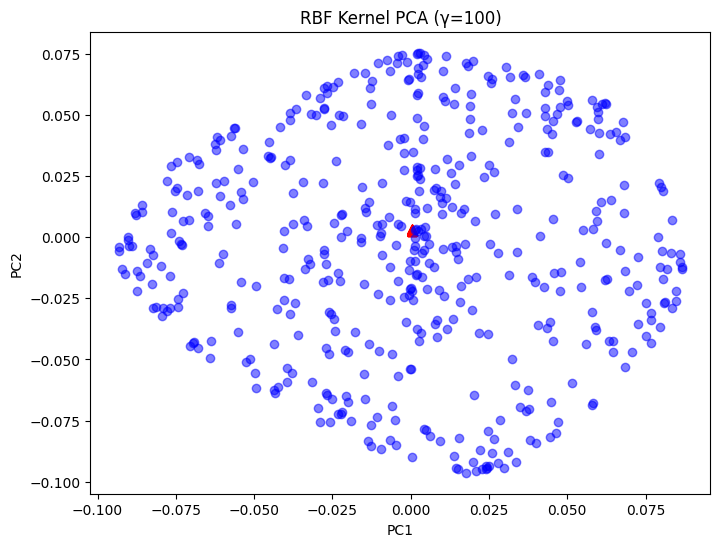

In [17]:
gammas = [0.01, 15, 100]

for gamma in gammas:
    X_kpca = rbf_kernel_pca(X, gamma=gamma, n_components=2)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], color='red', marker='^', alpha=0.5)
    plt.scatter(X_kpca[y==1, 0], X_kpca[y==1, 1], color='blue', marker='o', alpha=0.5)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(f'RBF Kernel PCA (γ={gamma})')
    plt.show()

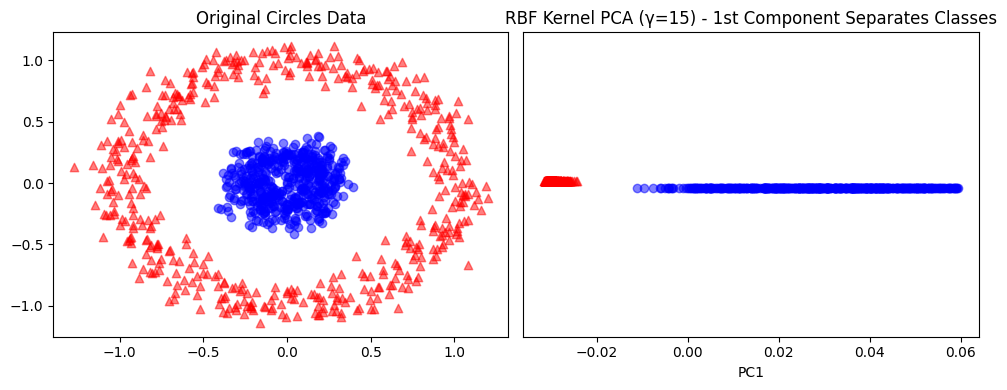

In [16]:

from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.scatter(X[y==0, 0], X[y==0, 1], color='red', marker='^', alpha=0.5)
ax1.scatter(X[y==1, 0], X[y==1, 1], color='blue', marker='o', alpha=0.5)
ax1.set_title('Original Circles Data')

ax2.scatter(X_kpca[y==0, 0], np.zeros((500,1)) + 0.02, color='red', marker='^', alpha=0.5) # Add slight y-jitter for visualization
ax2.scatter(X_kpca[y==1, 0], np.zeros((500,1)) - 0.02, color='blue', marker='o', alpha=0.5)
ax2.set_ylim([-1, 1])
ax2.set_yticks([])
ax2.set_xlabel('PC1')
ax2.set_title('RBF Kernel PCA (γ=15) - 1st Component Separates Classes')
plt.tight_layout()
plt.show()


In [13]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_kpca_sk = kpca.fit_transform(X)
